In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
from itertools import tee
import pingouin as pg
import pandas as pd
import tabulate
import yaml

from sklearn.manifold import TSNE
from sklearn.metrics import r2_score, roc_auc_score, roc_curve, f1_score
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC, SVR
from sklearn.decomposition import PCA

from scipy.stats import linregress, pearsonr
from scipy.stats import mannwhitneyu
from scipy.stats import f as f_oneway

from datautils import load_ftn
from contrastive_model import ContrastiveModel
from utils import init_dl_program

%matplotlib inline

# to make pdf fonts in vector
mpl.rcParams['pdf.fonttype'] = 42

sns.set_theme(style="whitegrid", palette="colorblind")
sns.set_context('paper')
plt.rcParams["patch.force_edgecolor"] = False  # Turn off histogram borders

In [2]:
def utest_with_effect(g1: np.ndarray, g2: np.ndarray):
    n1, n2 = len(g1), len(g2)
    u1, p = mannwhitneyu(g1, g2)
    u2 = n1 * n2 - u1
    f = u1 / (n1 * n2)  # Common language effect size; eq. to AUROC
    return u1, u2, f, p

In [3]:
def pairwise(iterable):
    "s -> (s0,s1), (s1,s2), (s2, s3), ..."
    a, b = tee(iterable)
    next(b, None)
    return zip(a, b)


def plot_results(gt_list, res_list, sub_list, diag_list_sub, label_predict, seg_len):
    """
    Generates and visualizes evaluation results for regression downstream tasks.

    Parameters:
    - gt_list (array-like): clinician scores.
    - res_list (array-like): Estimated scores from the model.
    - sub_list (array-like): List of subject identifiers and dates.
    - diag_list_sub (array-like): Diagnosis information for each subject (1 for ataxia, 0 for healthy).
    - label_predict (str): Label indicating the type of score being predicted.
    - seg_len (int): Segment length used in the evaluation.

    Returns:
    - r2 (float): R-squared value for cross-sectional evaluation.
    - rmse (float): Root Mean Squared Error for cross-sectional evaluation.
    - long_r (float): Pearson correlation coefficient for longitudinal evaluation.
    - long_p (float): p-value for longitudinal evaluation.
    """
    # Calculate evaluation metrics (R-squared, RMSE, Pearson correlation)
    r2 = r2_score(gt_list, res_list)
    rmse = np.sqrt(np.mean(np.square(gt_list - res_list)))
    cross_r, cross_p = pearsonr(gt_list, res_list)

    # Initialize variables to hold longitudinal analysis data
    date_diff, gt_diff, pred_diff, baseline, date_list = [], [], [], [], []
    detected = set()

    # Iterate over subjects and compute longitudinal differences
    for s in sub_list:
        date_list.append(np.datetime64('-'.join(s[6:].split('_'))))
        subject_id = s[:5]
        if subject_id not in detected:
            detected.add(subject_id)
            sub_same_ind = np.char.find(sub_list, subject_id) != -1
            if np.sum(sub_same_ind) >= 2:
                for (x1, y1, d1), (x2, y2, d2) in pairwise(zip(gt_list[sub_same_ind], res_list[sub_same_ind], sub_list[sub_same_ind])):
                    if diag_list_sub[sub_same_ind][0] != 0:
                        gt_diff.append(x2 - x1)
                        pred_diff.append(y2 - y1)
                        d2_date = np.datetime64('-'.join(d2[6:].split('_')))
                        d1_date = np.datetime64('-'.join(d1[6:].split('_')))
                        baseline.append(x1)
                        date_diff.append((d2_date - d1_date).astype('float'))

    gt_diff, pred_diff = np.array(gt_diff), np.array(pred_diff)


    # Create subplots for cross-sectional and longitudinal analysis
    fig, (fig_cross, fig_long) = plt.subplots(1, 2, figsize=(9, 4))
    fig_cross.scatter(gt_list[diag_list_sub == 1], res_list[diag_list_sub == 1], c='b', label='Ataxia')
    fig_cross.scatter(gt_list[diag_list_sub == 0], res_list[diag_list_sub == 0], c='g', label='Healthy')
    
    # Plot cross-sectional evaluation (scatter plot)
    min_val, max_val = min(np.min(res_list), np.min(gt_list)), max(np.max(res_list), np.max(gt_list))
    res = linregress(gt_list, res_list)
    fig_cross.plot([min_val - 0.5, max_val + 0.5], [res.intercept + res.slope * (min_val - 0.5), res.intercept + res.slope * (max_val + 0.5)], 'k--')
    fig_cross.plot([min_val - 0.5, max_val + 0.5], [min_val - 0.5, max_val + 0.5], 'k')
    fig_cross.set_xlabel(f'Clinician-scored {label_predict}')
    fig_cross.set_ylabel(f'Estimated {label_predict}')
    fig_cross.axis('square')
    fig_cross.legend()

    # Plot longitudinal evaluation (scatter plot)
    min_y, max_y = min(np.min(gt_diff), np.min(pred_diff)), max(np.max(gt_diff), np.max(pred_diff))
    cb = fig_long.scatter(gt_diff, pred_diff, c=baseline, cmap='viridis', vmin=np.min(gt_list), vmax=np.max(gt_list))
    res_diff = linregress(gt_diff, pred_diff)
    fig_long.plot([min_y - 0.5, max_y + 0.5], [res_diff.intercept + res_diff.slope * (min_y - 0.5), res_diff.intercept + res_diff.slope * (max_y + 0.5)], 'k--')
    fig_long.plot([min_y - 0.5, max_y + 0.5], [min_y - 0.5, max_y + 0.5], 'k')
    fig_long.set_xlabel(f'Diff. Clinician-scored {label_predict}')
    fig_long.set_ylabel(f'Diff. Estimated {label_predict}')
    fig_long.set_aspect('equal')
    fig_long.axvline(0, linestyle='--', color='r')
    fig_long.axhline(0, linestyle='--', color='r')
    clb = plt.colorbar(cb, ax=fig_long)
    clb.ax.tick_params(labelsize=8)
    clb.set_label('Clinician-scored Total BARS (Baseline)', rotation=270, fontsize=8, labelpad=10)

    plt.tight_layout()
    plt.savefig(f'{save_folder_name}/results_{label_predict}_{seg_len}.pdf')
    plt.show()

    # Calculate and print longitudinal Pearson correlation
    long_r, long_p = pearsonr(gt_diff, pred_diff)
    print(f'Cross-Sectional R2: {r2:.2f}, RMSE: {rmse:.2f}, Pearson r: {cross_r:.2f}, p: {cross_p:.3f} /  Longitudinal r: {long_r:.2f}, p: {long_p:.3f}')

    return r2, rmse, cross_r, cross_p, long_r, long_p


In [4]:
with open('config.yaml', 'r') as file:
        cfg = yaml.safe_load(file)

run_name = cfg.get('run_name', 'ftn_no_rotate')
gpu = cfg.get('gpu', '0')
batch_size = cfg.get('batch_size', 32)
lr = cfg.get('lr', 0.001)
repr_dims = cfg.get('repr_dims', 320)
epochs = cfg.get('epochs', 200)
seed = cfg.get('seed', 42)
max_threads = cfg.get('max_threads', 8)
freq = cfg.get('freq', 128)
seg_length_sec = cfg.get('seg_length_sec', 10)
cv_num = cfg.get('cv_num', 5)
seg_length = freq * seg_length_sec

save_folder_name = '../ts2vec/mean_embeddings_random_rotall'
model_folder_name = '../ts2vec/seglen_performance_random_rotall'

seg_length_list = []
file_list = np.array(os.listdir(model_folder_name))
for files in file_list:
    if "." not in files:
        seg_length_list.append(int(files.split('_')[-1]))
    else:
        seg_length_list.append(np.nan)
seg_length_list = np.array(seg_length_list)
file_list = file_list[~np.isnan(seg_length_list)]
seg_length_list = seg_length_list[~np.isnan(seg_length_list)]
seg_length_idx = np.argsort(seg_length_list)
seg_length_list = seg_length_list[seg_length_idx]
file_list = file_list[seg_length_idx]

In [5]:
metrics = {
    'r2': [],
    'rmse': [],
    'cross_corr': [],
    'cross_pval': [],
    'longitudinal_corr': [],
    'longitudinal_pval': [],
    'auc': []
}

def store_metrics(metrics, r2, rmse, cross_r, cross_p, long_r, long_p, auc):
    metrics['r2'].append(r2)
    metrics['rmse'].append(rmse)
    metrics['cross_corr'].append(cross_r)
    metrics['cross_pval'].append(cross_p)
    metrics['longitudinal_corr'].append(long_r)
    metrics['longitudinal_pval'].append(long_p)
    metrics['auc'].append(auc)

def compute_auc(gt_cl_list, pred_cl_list, diag_list_sub, gt_arm_list):
    fpr, tpr, _ = roc_curve(gt_cl_list, pred_cl_list)
    fpr_armz, tpr_armz, _ = roc_curve(gt_cl_list[np.logical_or(np.logical_and(diag_list_sub != 0, gt_arm_list == 0), diag_list_sub == 0)], 
                                              pred_cl_list[np.logical_or(np.logical_and(diag_list_sub != 0, gt_arm_list == 0), diag_list_sub == 0)])
    auc_arm_z = utest_with_effect(pred_cl_list[np.logical_and(diag_list_sub != 0, gt_arm_list == 0)], pred_cl_list[diag_list_sub == 0])[2]
    print(utest_with_effect(pred_cl_list[diag_list_sub != 0], pred_cl_list[diag_list_sub == 0]))
    print(utest_with_effect(pred_cl_list[np.logical_and(diag_list_sub != 0, gt_arm_list == 0)], pred_cl_list[diag_list_sub == 0]))

    auc = roc_auc_score(gt_cl_list, pred_cl_list)
    fig_cl = plt.figure(figsize=(8, 4))
    ax = fig_cl.add_subplot(1, 2, 1)
    ax.plot(fpr, tpr, label="AUC = {:.2}".format(auc))
    ax.set_xlabel("False Positive Rate")
    ax.set_ylabel("True Positive Rate")
    plt.legend()
    ax = fig_cl.add_subplot(1, 2, 2)
    ax.plot(fpr_armz, tpr_armz, label="AUC = {:.2}".format(auc_arm_z))
    ax.set_xlabel("False Positive Rate")
    ax.set_ylabel("True Positive Rate")
    plt.legend()
    plt.tight_layout()
    plt.savefig(save_folder_name + '/cl_results_{}.pdf'.format(seg_length))
    plt.show()
    return auc


    

In [6]:
def train_svr(X_train, y_train):
    grid_search = GridSearchCV(SVR(), {'C': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000], 'kernel': ['rbf'], 'gamma': ['scale']}, cv=10, n_jobs=4)
    grid_search.fit(X_train, y_train)
    return grid_search.best_estimator_


def train_svc(X_train, y_train):
    grid_search = GridSearchCV(SVC(probability=True), {'C': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000], 'kernel': ['rbf'], 'gamma': ['scale']}, cv=10, n_jobs=4)
    grid_search.fit(X_train, y_train)
    return grid_search.best_estimator_

64 0.5


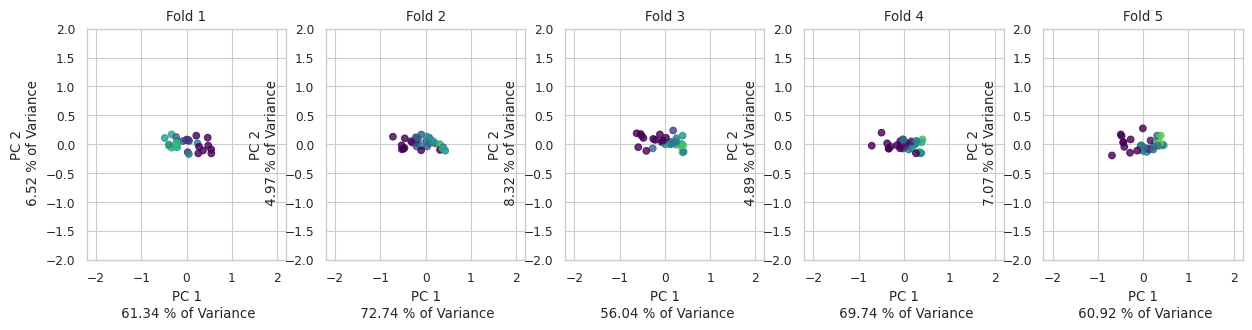

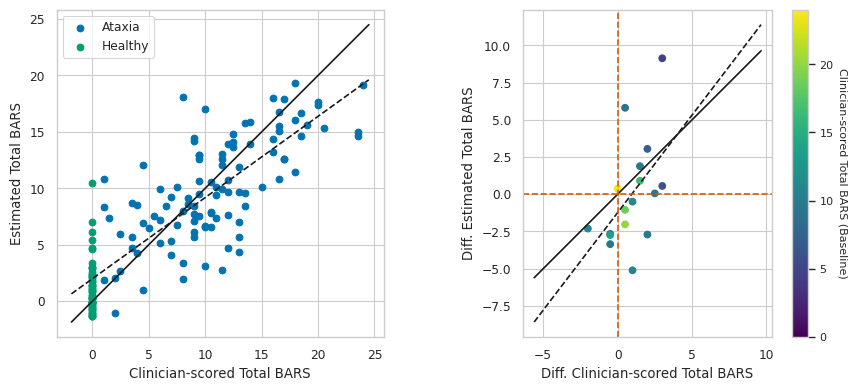

Cross-Sectional R2: 0.70, RMSE: 3.62, Pearson r: 0.84, p: 0.000 /  Longitudinal r: 0.51, p: 0.038


ValueError: operands could not be broadcast together with shapes (153,) (0,) 

In [7]:

for files in file_list:
    seg_length = int(files.split('_')[-1])
    print(seg_length, seg_length / freq)
    if (seg_length/ freq) > 20:
        break

    device = init_dl_program('cpu', seed=seed, max_threads=8, deterministic=False)
    train_set = load_ftn(cv_num, seg_length, is_train=True)

    device = init_dl_program('cpu', seed=seed, max_threads=8, deterministic=False)
    test_set = load_ftn(cv_num, seg_length, is_train=False, overlap_test=seg_length)

    sub_list = []
    diag_list = []
    gt_list = []
    gt_arm_list = []
    gt_l_list = []
    gt_r_list = []
    gt_cl_list = []
    pred_list = []
    pred_l_list = []
    pred_r_list = []
    pred_cl_list = []
    pred_first_list = []
    pred_second_list = []
    pred_arm_list = []
    non_lr_list = []
    non_ts_list = []
    embed_pca_list = []
    age_list = []
    pred_variability = []
    all_test_embed = []
    
    fig_pca = plt.figure(figsize = (18, 3))
    for cv in range(cv_num):
        model = ContrastiveModel(
            input_dims=train_set[cv]['data'].shape[-1],
            device=device,
        )
        train_sub_date = train_set[cv]['sub_date']
        test_sub_date = test_set[cv]['sub_date']
        test_arm = test_set[cv]['arm']
        
        # Load the trained model
        model.load(os.path.join(model_folder_name, files, 'model_{}.pkl'.format(cv)))

        # Encode representations
        train_repr = model.encode(train_set[cv]['data'], encoding_window='full_series', batch_size=128)
        test_repr = model.encode(test_set[cv]['data'], encoding_window='full_series', batch_size=128)

        # aggregate represensetions for each subject and session
        X_train = np.array([train_repr[train_sub_date == ss, :].mean(axis=0) for ss in np.unique(train_sub_date)])
        X_test = np.array([test_repr[test_sub_date == ss, :].mean(axis=0) for ss in np.unique(test_sub_date)])

        # labels for regression and classification task
        y_train_total = np.array([train_set[cv]['total_bars'][train_sub_date == ss].mean() for ss in np.unique(train_sub_date)])
        y_test_total = np.array([test_set[cv]['total_bars'][test_sub_date == ss].mean() for ss in np.unique(test_sub_date)])
        y_train_cl = np.array([train_set[cv]['diag'][train_sub_date == ss][0] for ss in np.unique(train_sub_date)])
        y_test_cl = np.array([test_set[cv]['diag'][test_sub_date == ss][0] for ss in np.unique(test_sub_date)])

        # train SVR, SVC for regression and classification task
        svr_model = train_svr(X_train, y_train_total)
        svc_model = train_svc(X_train, y_train_cl)

        pred_list.extend(svr_model.predict(X_test))
        pred_cl_list.extend(svc_model.predict_proba(X_test)[:, 1])

        gt_list.extend(y_test_total)
        gt_cl_list.extend(y_test_cl)

        sub_list.extend([ss for ss in np.unique(test_sub_date)])
        diag_list.extend([test_set[cv]['diag'][test_sub_date == ss] for ss in np.unique(test_sub_date)])
        age_list.extend([test_set[cv]['age'][test_sub_date == ss][0] for ss in np.unique(test_sub_date)])

          
        ax = fig_pca.add_subplot(1, 6, cv+1)
        pca = PCA(n_components=2)
        pca.fit(X_train)
        embed_pca = pca.transform(X_test)
        pca_1_sign = [1, -1, -1, -1, -1]
        pca_2_sign = [1, 1, 1, 1, 1]
        embed_pca[:, 0] = embed_pca[:, 0] * pca_1_sign[cv]
        embed_pca[:, 1] = embed_pca[:, 1] * pca_2_sign[cv]
        cb = ax.scatter(embed_pca[:, 0], embed_pca[:, 1], c=y_test_total, alpha=0.8, cmap='viridis', vmin=0, vmax=25)
        embed_pca_list.extend(embed_pca)
        ax.set_xlabel(f'PC 1\n {pca.explained_variance_ratio_[0]*100:.2f} % of Variance')
        ax.set_ylabel(f'PC 2\n {pca.explained_variance_ratio_[1]*100:.2f} % of Variance')
        ax.set_title(f'Fold {cv+1}')
        ax.set_xlim([-2.2, 2.2])
        ax.set_ylim([-2, 2])
        embed_pca_each = pca.transform(test_repr)
        embed_pca_each[:, 0] = embed_pca_each[:, 0] * pca_1_sign[cv]
        embed_pca_each[:, 1] = embed_pca_each[:, 1] * pca_2_sign[cv]

       
       
        
        
    embed_pca_list = np.array(embed_pca_list)
    diag_list = np.array(diag_list, dtype='object')
    diag_list_sub = np.array([d[0] for d in diag_list])
    age_list = np.array(age_list)
    sub_list = np.array(sub_list)
    gt_list = np.array(gt_list)
    gt_l_list = np.array(gt_l_list)
    gt_r_list = np.array(gt_r_list)
    gt_arm_list = np.array(gt_arm_list)
    gt_cl_list = np.array(gt_cl_list)
    pred_list = np.array(pred_list)
    pred_l_list = np.array(pred_l_list)
    pred_r_list = np.array(pred_r_list)
    pred_first_list = np.array(pred_first_list)
    pred_second_list = np.array(pred_second_list)
    pred_arm_list = np.array(pred_arm_list)
    pred_cl_list = np.array(pred_cl_list)
    non_lr_list = np.array(non_lr_list)
    non_ts_list = np.array(~np.isnan(non_ts_list))


    r2, rmse, cross_r, cross_p, long_r, long_p = plot_results(gt_list, pred_list, sub_list, diag_list_sub, 'Total BARS', seg_length)

    auc = compute_auc(gt_cl_list, pred_cl_list, diag_list_sub, gt_arm_list)

    store_metrics(metrics, r2, rmse, cross_r, cross_p, long_r, long_p, auc)



    ax = fig_pca.add_subplot(1, 6, 6)
    cb = ax.scatter(embed_pca_list[:, 0], embed_pca_list[:, 1], c=gt_list, alpha=0.8, cmap='viridis', vmin=0, vmax=25)
    clb = plt.colorbar(cb)
    clb.ax.tick_params(labelsize=8) 
    clb.ax.set_ylabel('Clinician-scored Total BARS', rotation=270, fontsize=8)
    ax.set_xlabel(f'PC 1')
    ax.set_ylabel(f'PC 2')
    ax.set_title(f'Combined')
    ax.set_xlim([-2.2, 2.2])
    ax.set_ylim([-2, 2])
    plt.tight_layout()
    plt.savefig(save_folder_name + '/pca_{}.pdf'.format(seg_length))    
    plt.show() 
    print('pc1 vs. gt', pearsonr(embed_pca_list[:, 0], gt_list))
    print('pc2 vs. gt', pearsonr(embed_pca_list[:, 1], gt_list))


    


In [ ]:
column_names = ['Sequence Length (sec)', '$R^2$\n(Total BARS)', 'RMSE\n(Total BARS)', 'Cross-sectional correlation $r$\n(Total BARS)', 'Cross-sectional correlation\n$p$-value (Total BARS)',
                'Longitudianl correlation $r$\n(Total BARS)', 'Longitudianl correlation\n$p$-value (Total BARS)',
               'Healthy vs. Ataxia AUC']
results_all = [list(seg_length_list/freq), list(np.round(metrics['r2'], 2)), list(np.round(metrics['rmse'],2)), list(np.round(metrics['cross_corr'], 2)), list(np.round(metrics['cross_pval'], 3)), 
               list(np.round(metrics['longitudinal_corr'], 2)), list(np.round(metrics['longitudinal_pval'], 3)), list(np.round(metrics['auc'], 2))]
results_all = map(list, zip(*results_all))

table = tabulate.tabulate(results_all, tablefmt='html', headers=column_names)
table